In [1]:
# import the geostrophic CDF tool AMOC 
import numpy as np
import xarray as xr


In [2]:
geo_mocs = []

for i in range(5):
    geo_moc = xr.open_dataset(f'data/viking20x-data/geo_moc_transport_0{i+1}.nc')
    if i > 0:
        geo_moc['time_counter'] = (geo_moc.time_counter.values.astype('datetime64[s]') + np.timedelta64(50*i, 'Y').astype('timedelta64[D]')).astype('datetime64[ns]')
    geo_mocs.append(geo_moc)

geo_moc = xr.concat(geo_mocs, dim='time_counter')
geo_moc = geo_moc.zomsfatl_sh.isel(depthw = 24)

/opt/homebrew/Caskroom/miniconda/base/envs/rapid-geostrophic-recons/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  index_grouper = pd.Grouper(


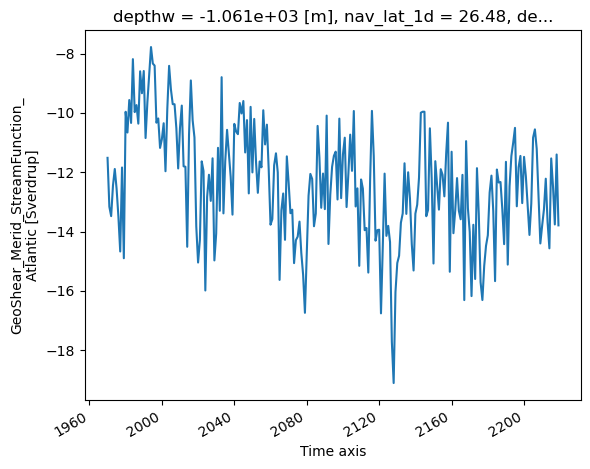

In [3]:

geo_moc.resample(time_counter = 'AS').mean().plot()

In [4]:
# open a pickle file
import pickle

def load_mooring(mooring_version):
    with open(f'data/viking20x-data/argo_profiles_moorings_{mooring_version}.p', 'rb') as f:
        m = pickle.load(f)

    return m


def transform_mooring_data(mooring_sec):
    mooring = load_mooring(mooring_sec)

    mooring_profiles = []

    for i in range(mooring.shape[0]):
        mooring_profiles.append(np.atleast_1d(mooring.isel(time_counter = i).values)[0])

    mooring = xr.DataArray(np.stack(mooring_profiles), dims = ['time_counter', 'mooring', 'feature'], coords = {'time_counter': mooring.time_counter})

    return mooring


moorings = []

for i in range(5):
    mooring = transform_mooring_data(f'0{i+1}')
    if i > 0:
        mooring['time_counter'] = (mooring.time_counter.values.astype('datetime64[s]') + np.timedelta64(50*i, 'Y').astype('timedelta64[D]')).astype('datetime64[ns]')
    moorings.append(mooring)

mooring = xr.concat(moorings, dim='time_counter')

In [5]:
depth = xr.open_dataarray('data/viking20x-data/depth.nc').rename({'deptht': 'depth'})

In [6]:
mooring_temperature = mooring.isel(feature = slice(3, 3+46)).rename({'feature': 'depth'}).assign_coords({'depth': depth})
mooring_salinity = mooring.isel(feature = slice(49, 49+46)).rename({'feature': 'depth'}).assign_coords({'depth': depth})

mooring_temperature = mooring_temperature.where(mooring_temperature != 0)
mooring_salinity = mooring_salinity.where(mooring_salinity != 0)

In [7]:
import gsw.conversions as conversions
import gsw.density as density


In [8]:

conservative_temperature = xr.apply_ufunc(conversions.CT_from_pt, mooring_salinity, mooring_temperature)
rho = xr.apply_ufunc(density.rho, mooring_salinity, conservative_temperature, conservative_temperature.depth)
rho = rho - 1000 
rho = rho.isel(depth = slice(10,35))

In [9]:
# Finished the preprocessing!

geo_moc = geo_moc.resample(time_counter = '1M').mean()
rho = rho.resample(time_counter = '1M').mean()

/opt/homebrew/Caskroom/miniconda/base/envs/rapid-geostrophic-recons/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/opt/homebrew/Caskroom/miniconda/base/envs/rapid-geostrophic-recons/lib/python3.9/site-packages/xarray/core/groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


In [10]:
train_set = xr.concat([rho.sel(time_counter=slice(None, '2033-12-31')), rho.sel(time_counter=slice('2121-01-01', None))], dim = 'time_counter') 
test_set = rho.sel(time_counter=slice('2034-01-01', '2120-12-31'))

train_output = xr.concat([geo_moc.sel(time_counter=slice(None, '2033-12-31')), geo_moc.sel(time_counter=slice('2121-01-01', None))], dim = 'time_counter') 
test_output = geo_moc.sel(time_counter=slice('2034-01-01', '2120-12-31'))


rho_mean_train = train_set.mean(dim = ['time_counter', 'mooring'], skipna = True)
rho_std_train = train_set.std(dim = ['time_counter', 'mooring'], skipna = True)

train_set = (train_set - rho_mean_train) / rho_std_train
test_set = (test_set - rho_mean_train) / rho_std_train


#stack the depth and mooring dimensions
train_set = train_set.stack(features = ['mooring', 'depth'])
test_set = test_set.stack(features = ['mooring', 'depth'])



train_set = train_set.fillna(0).values
test_set = test_set.fillna(0).values



Epoch [001/300], Loss: 39.97156966217165
Epoch [002/300], Loss: 10.441051558750432
Epoch [003/300], Loss: 10.381436402235574
Epoch [004/300], Loss: 9.718643925054286
Epoch [005/300], Loss: 9.616071877440787
Epoch [006/300], Loss: 9.928616890093176
Epoch [007/300], Loss: 9.315571288752363
Epoch [008/300], Loss: 9.794425972108918
Epoch [009/300], Loss: 9.658397314025134
Epoch [010/300], Loss: 9.591968873652016
Epoch [011/300], Loss: 9.200822673192839
Epoch [012/300], Loss: 8.999499784252508
Epoch [013/300], Loss: 9.397534122311972
Epoch [014/300], Loss: 9.41613762359309
Epoch [015/300], Loss: 9.416254450635213
Epoch [016/300], Loss: 9.139441411669662
Epoch [017/300], Loss: 9.014641217099943
Epoch [018/300], Loss: 9.162238477691401
Epoch [019/300], Loss: 9.19840199385232
Epoch [020/300], Loss: 8.809729830036318
Epoch [021/300], Loss: 8.914993912223878
Epoch [022/300], Loss: 9.133399255876618
Epoch [023/300], Loss: 8.933276675580963
Epoch [024/300], Loss: 9.018134413695917
Epoch [025/300],

/opt/homebrew/Caskroom/miniconda/base/envs/rapid-geostrophic-recons/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1044])) that is different to the input size (torch.Size([1044, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.14378374814987183

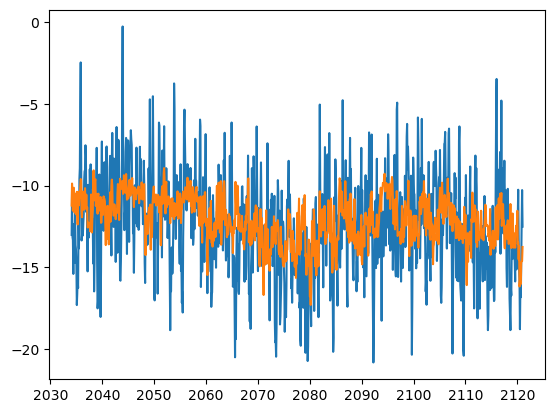

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.hidden_dim = 32
        self.dropout = nn.Dropout(0.35)
        self.linear1 = nn.Linear(input_size, self.hidden_dim)
        self.linear2 = nn.Linear(self.hidden_dim,self.hidden_dim)
        self.linear2a = nn.Linear(self.hidden_dim,self.hidden_dim)
        self.linear2b= nn.Linear(self.hidden_dim,self.hidden_dim)
        self.linear3 = nn.Linear(self.hidden_dim, output_size)
    
    def forward(self, x):
        x = self.dropout(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        # x = self.linear2a(x)
        # x = F.relu(x)
        # x = self.linear2b(x)
        # x = F.relu(x)
        x = self.linear3(x)
        return x


# Set the random seed for reproducibility
torch.manual_seed(42)

input_size = train_set.shape[1]
output_size = 1

# Define the model
model = LinearModel(input_size, output_size)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs
num_epochs = 300

# Convert the inputs and outputs to PyTorch tensors
train_set_torch = torch.tensor(train_set, dtype=torch.float32)
train_output_torch = torch.tensor(train_output.values.reshape(-1, 1), dtype=torch.float32)

# put the data into a dataloader
train_data = torch.utils.data.TensorDataset(train_set_torch, train_output_torch)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    total_loss = 0
    for i, (inputs, outputs) in enumerate(train_loader):        
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, outputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Print the loss for every epoch
    print(f"Epoch [{epoch+1:03d}/{num_epochs:03d}], Loss: {total_loss / len(train_loader)}")


# Evaluate the model on the test set
model.eval()
test_set_torch = torch.tensor(test_set, dtype=torch.float32)
test_output_torch = torch.tensor(test_output.values, dtype=torch.float32)
output = model(test_set_torch)
loss = criterion(output, test_output_torch)
print(f"Test loss: {loss.item()}")

# Plot the results
plt.plot(test_output.time_counter, test_output)
plt.plot(test_output.time_counter, output.detach().numpy())


from sklearn.metrics import explained_variance_score

explained_variance_score(test_output.values, output.detach().numpy())

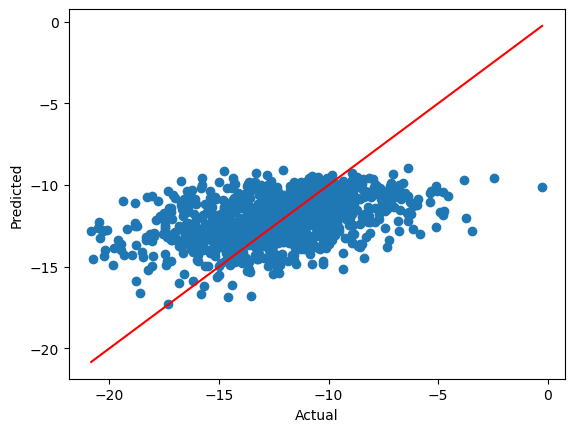

In [12]:
# Make a scatter plot of the predicted vs actual values
plt.scatter(test_output.values, output.detach().numpy())
plt.xlabel('Actual')
plt.ylabel('Predicted')

min_value = min(test_output.values.min(), output.detach().numpy().min())
max_value = max(test_output.values.max(), output.detach().numpy().max())
plt.plot([min_value, max_value], [min_value, max_value], color='red')